# Sr. Analysis Project
## Sep 4, 2023

### Objective
Identify the addressable music consumer market for Spotify assuming an individual account cost of **$10.99 per month**. Specifically, assess the opportunity in countries with large populations, focusing on emerging markets in SSA (Sub-Saharan Africa) and SEA (Southeast Asia), while taking into account their high poverty levels.

### Data Sources
- **Population Data**: [World Population Prospects - Population Division - United Nations](https://population.un.org/wpp/Download/Standard/Population/)
- **Poverty Data**: Average daily income by percentile from the World Bank. The data is assumed to be distributed equally across all age groups. [Poverty and Inequality Platform (PIP): Percentiles | Data Catalog](https://datacatalog.worldbank.org/search/dataset/0063646)

### Age Demographics
The analysis focuses on the following age groups:
- `<18`
- `18-22`
- `23-27`
- `28-34`
- `35-44`
- `45-59`
- `60+`

### Deliverables
- A concise analysis report, capped at **10 pages** that includes tables, graphs, and a summary of findings.
- Source code for the analysis, which could be in Python, SQL or any other relevant language. The code should be well-documented.

### Evaluation Criteria
- Clarity of analysis
- Organization of work
- Attention to detail

> Note: The use of additional data sources is encouraged.

In [ ]:
# Define Year:
YEAR = 2022

In [ ]:
%pip install pycountry
%pip install geopandas matplotlib
%pip install openpyxl

Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.


# Define Functions

In [ ]:
# Standard library imports #
import datetime
import time
from itertools import combinations
from collections import defaultdict, Counter
import os

# Third party imports
import boto3
import json
import networkx as nx
import numpy as np
import pandas as pd
import snowflake.connector
from tqdm import tqdm 
import pycountry

# sklearn imports
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier

/local_disk0/.ephemeral_nfs/cluster_libraries/python/lib/python3.9/site-packages/snowflake/connector/options.py:103: UserWarning: You have an incompatible version of 'pyarrow' installed (7.0.0), please install a version that adheres to: 'pyarrow<10.1.0,>=10.0.1; extra == "pandas"'
  warn_incompatible_dep(


#### Data ETL

In [ ]:
# Snowflake secrets from JINGBIN PERSONAL ACCOUNT FROM DATABRICKS
def pull_snowflake_secrets_jingbin(scope):
    """Return dict of secrets used for snowflake queries.
    The current implementation queries Databricks secrets for username and password.
    The secrets are returned as a dict.
    Args:
        scope (str): the scope name containing the secrets
    Returns:
        dict: a dict with keys "username" and "password"
    """
    # DBUtils require a SparkContext, if you're using this in a non-spark context, you might have to initialize a SparkContext first.
    dbutils = DBUtils(spark)
    
    scope = "jingbin_snowflake" # Change this scope for another secrets

    secrets = {
        "username": dbutils.secrets.get(scope=scope, key="username"),
        "password": dbutils.secrets.get(scope=scope, key="password"),
    }
    return secrets


def execute_snowflake_query(query, scope = "jingbin_snowflake"): # Change to personal scope
    """Runs a Snowflake query and returns a pandas dataframe.
    Args:
        query (str): query string to execute
        scope (str): the scope name containing the secrets
    Returns:
        pd.DataFrame
    """
    secrets = pull_snowflake_secrets_jingbin(scope)

    with snowflake.connector.connect(
        user=secrets["username"],
        password=secrets["password"],
        account="wmg-datalab",
        authenticator = "https://wmg.okta.com",
        warehouse="DATA_SCIENCE_SANDBOX_WH_XL",
        database="DATA_SCIENCE_SANDBOX",
        schema="JINGBIN_C",
    ).cursor() as cs:
        cur = cs.execute(query)
        results = pd.DataFrame.from_records(
            iter(cur), columns=[c[0] for c in cur.description]
        )
        results.columns = [str.lower(c) for c in results.columns]
    return results
  

scope = "jingbin_snowflake"
secrets = pull_snowflake_secrets_jingbin(scope)

# To Datalab database
sfOptions = {
  "sfUrl": "https://wmg-datalab.snowflakecomputing.com/",
  "sfUser": secrets["username"],
  "sfauthenticator":'https://wmg.okta.com',
  "sfPassword": secrets["password"],
  "sfDatabase": 'DATA_SCIENCE_SANDBOX',
  "sfSchema": 'JINGBIN_C',
  "sfWarehouse": 'DATA_SCIENCE_SANDBOX_WH_XL',
  "sfRole": 'ENT_OKTA_SNOWFLAKE_DATALAB_DATA_SCIENCE'
}

In [ ]:
def save_to_csv(dataframe, folder='./data', filename='summary_table.csv'):
    """
    Save a DataFrame to a CSV file.

    Parameters:
        dataframe (DataFrame): DataFrame to save.
        folder (str): Directory where the CSV file will be saved.
        filename (str): The name of the CSV file.
    """
    # Create the folder if it does not exist
    if not os.path.exists(folder):
        os.makedirs(folder)

    # Define the full path for the file
    filepath = os.path.join(folder, filename)

    # Save DataFrame to CSV
    dataframe.to_csv(filepath, index=False)
    print(f"Data saved to {filepath}")

#### Poverty Data

In [ ]:
import pandas as pd
import pycountry

def three_to_two_alpha(code):
    try:
        return pycountry.countries.get(alpha_3=code).alpha_2
    except AttributeError:
        return code

def analyze_poverty_data_pandas(file_path):
    all_insights = []
    df = pd.read_csv(file_path)
    df['country_code_2_letter'] = df['country_code'].apply(three_to_two_alpha)
    unique_countries = df['country_code'].unique()

    for country in unique_countries:
        print(f"Generating insights for country: {country}")
        df_country = df[df['country_code'] == country].copy()
        bins = [0, 25, 50, 75, 100]
        labels = ['1~25', '26~50', '51~75', '76~100']
        df_country.loc[:, 'Percentile_Bin'] = pd.cut(df_country['percentile'], bins=bins, labels=labels, right=True)

        insights = df_country.groupby(
            ['country_code_2_letter', 'country_code', 'year', 'Percentile_Bin', 'reporting_level', 'welfare_type']
        ).agg({
            'avg_welfare': [('Mean_Welfare', 'mean')],
            'quantile': [('Max_Quantile', 'max'), ('Min_Quantile', 'min')],
            'pop_share': [('Total_Pop_Share', 'sum')],
            'welfare_share': [('Total_Welfare_Share', 'sum')]
        }).reset_index()

        # Flatten the multi-level column index
        insights.columns = ['_'.join(col).rstrip('_') for col in insights.columns.values]

        # Rename columns for brevity
        insights.rename(columns={
            'avg_welfare_Mean_Welfare': 'Mean_Welfare',
            'quantile_Max_Quantile': 'Max_Quantile',
            'quantile_Min_Quantile': 'Min_Quantile',
            'pop_share_Total_Pop_Share': 'Total_Pop_Share',
            'welfare_share_Total_Welfare_Share': 'Total_Welfare_Share'
        }, inplace=True)

        all_insights.append(insights)

    concatenated_insights = pd.concat(all_insights, ignore_index=True)
    return concatenated_insights

def get_national_median_welfare(df, percentile = 50):
    """
    Filters the DataFrame for specific reporting levels and 50th percentile.
    Adds or updates 'national' records with the average of 'rural' and 'urban' when possible, or
    uses either 'rural' or 'urban' if one of them is missing.
    
    Parameters:
        df (DataFrame): DataFrame containing poverty data.
        
    Returns:
        median_welfare_df (DataFrame): DataFrame containing updated median welfare data.
    """
    
    # Filter for 'national', 'rural', and 'urban' reporting levels and 50th percentile
    filtered_df = df[(df['reporting_level'].isin(['national', 'rural', 'urban'])) & 
                     (df['percentile'] == percentile)]
    
    # Keep relevant columns
    selected_columns = ['country_code', 'year', 'reporting_level', 'welfare_type', 'avg_welfare']
    filtered_df = filtered_df[selected_columns]
    
    # Calculate median welfare by group
    median_welfare_df = filtered_df.groupby(['country_code', 'year', 'reporting_level', 'welfare_type']).median().reset_index()
    
    # Placeholder for new 'national' rows
    new_national_rows = []
    
    # Iterate over unique country, year, and welfare_type combinations
    unique_combinations = median_welfare_df.groupby(['country_code', 'year', 'welfare_type']).size().reset_index()
    
    for _, row in unique_combinations.iterrows():
        country = row['country_code']
        year = row['year']
        welfare_type = row['welfare_type']
        
        # Fetch rural and urban values
        rural_value = median_welfare_df.loc[
            (median_welfare_df['country_code'] == country) &
            (median_welfare_df['year'] == year) &
            (median_welfare_df['welfare_type'] == welfare_type) &
            (median_welfare_df['reporting_level'] == 'rural'), 'avg_welfare'].values
        
        urban_value = median_welfare_df.loc[
            (median_welfare_df['country_code'] == country) &
            (median_welfare_df['year'] == year) &
            (median_welfare_df['welfare_type'] == welfare_type) &
            (median_welfare_df['reporting_level'] == 'urban'), 'avg_welfare'].values
        
        # Initialize avg_value to None
        avg_value = None
        
        # Apply new logic to calculate national value
        if rural_value.size > 0 and urban_value.size > 0:
            avg_value = (rural_value[0] + urban_value[0]) / 2
        elif rural_value.size > 0 and urban_value.size == 0:
            avg_value = rural_value[0]
        elif rural_value.size == 0 and urban_value.size > 0:
            avg_value = urban_value[0]
        
        # If avg_value has been updated, add a new 'national' row
        if avg_value is not None:
            new_national_rows.append({
                'country_code': country,
                'year': year,
                'reporting_level': 'national',
                'welfare_type': welfare_type,
                'avg_welfare': avg_value
            })
                
    # Add new 'national' rows to DataFrame
    if new_national_rows:
        median_welfare_df = pd.concat([median_welfare_df, pd.DataFrame(new_national_rows)], ignore_index=True)
    
    # Rename 'avg_welfare' to 'med_welfare'
    median_welfare_df.rename(columns={'avg_welfare': 'med_welfare'}, inplace=True)
    
    return median_welfare_df

#### Poverty Data Visualization

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import fiona
import pandas as pd
import geopandas as gpd

def read_shapefile_with_restore(shapefile_path):
    with fiona.Env(SHAPE_RESTORE_SHX='YES'):
        return gpd.read_file(shapefile_path)


def visualize_poverty_world_map(df, world, key_column_world='ISO_A3', key_column_df='country_code'):
    """
    Visualize the world map and display the DataFrame that shows the data used for plotting.
    
    Parameters:
        df (DataFrame): DataFrame containing med_welfare data.
        world (GeoDataFrame): GeoDataFrame containing the world map data.
        key_column_world (str): The key column in the world GeoDataFrame for merging.
        key_column_df (str): The key column in the DataFrame for merging.
        
    Returns:
        None
    """
    
    # Filter DataFrame to only include rows where reporting_level is 'national'
    df = df[df['reporting_level'] == 'national']
    
    # Further filter DataFrame to include only the latest year for each country
    df = df.loc[df.groupby([key_column_df])['year'].idxmax()]
    
    # Create the DataFrame used for plotting, which includes max med_welfare along with year, country, and welfare_type
    df = df[[key_column_df, 'year', 'welfare_type', 'med_welfare']]
    
    # Merge the GeoDataFrame with the filtered DataFrame
    merged_world = world.merge(df, how="left", left_on=key_column_world, right_on=key_column_df)
    
    # Create the plot
    fig, ax = plt.subplots(1, 1, figsize=(23, 18))
    merged_world.boundary.plot(ax=ax)
    cax = merged_world.plot(column='med_welfare', 
                            ax=ax, 
                            legend=True, 
                            cmap='OrRd', 
                            missing_kwds={"color": "lightgrey"},
                            legend_kwds={'orientation': "horizontal", 'shrink': 0.5, 'aspect': 50})
    
    # Customize the colorbar size and orientation
    cbar = cax.get_figure().get_axes()[1]
    cbar.set_title('Median Welfare')
    
    # Add labels and title
    plt.title('Median Welfare by Country in the Latest Available Year (National Level)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    plt.show()
    
    # Display the DataFrame used for plotting
    print("Data used for plotting:")
    print("========================")
    print(df)

#### Population Data

In [ ]:
import pandas as pd
import pycountry

def read_excel_from_dbfs(file_path, sheet_name):
    """
    Reads an Excel file from a given DBFS file path and returns a DataFrame.
    
    Parameters:
        - file_path (str): The path to the Excel file on DBFS.
        - sheet_name (str): The name of the sheet you want to read.
        
    Returns:
        - DataFrame: A DataFrame containing the data from the specified Excel sheet.
    """
    # Reading Excel file
    # Skip the first 16 rows, as variable names are in row 17 (0-indexed)
    df = pd.read_excel(file_path, sheet_name=sheet_name, skiprows=range(0, 16), header=0)
    
    return df
  
def convert_code_to_alpha(code):
    try:
        country = pycountry.countries.get(numeric=str(int(code)))
        return country.alpha_3, country.alpha_2
    except:
        return None, None

def transform_population_data(df, year = 2022):
    # Rename the column from '100+' to 100
    df.rename(columns={'100+': 100}, inplace=True)
    
    # Step 0: Filter data for the year 2022
    df_2022 = df[df['Year'] == year].copy()
    
    # Step 1: Convert location code to 3-letter and 2-letter country codes
    df_2022['ISO3 Alpha-code'], df_2022['ISO2 Alpha-code'] = zip(*df_2022['Location code'].map(convert_code_to_alpha))

    # Drop rows with NA values in ISO codes
    df_2022.dropna(subset=['ISO3 Alpha-code', 'ISO2 Alpha-code'], inplace=True)
    
    # Step 2: Keep only necessary columns
    age_columns = list(range(0, 100)) + [100]
    columns_to_keep = ['Location code', 'ISO3 Alpha-code', 'ISO2 Alpha-code'] + age_columns
    df_filtered = df_2022.loc[:, columns_to_keep]
    
    # Step 3: Group into age buckets
    df_filtered['<18'] = df_filtered.loc[:, range(0, 18)].sum(axis=1)
    df_filtered['18-22'] = df_filtered.loc[:, range(18, 23)].sum(axis=1)
    df_filtered['23-27'] = df_filtered.loc[:, range(23, 28)].sum(axis=1)
    df_filtered['28-34'] = df_filtered.loc[:, range(28, 35)].sum(axis=1)
    df_filtered['35-44'] = df_filtered.loc[:, range(35, 45)].sum(axis=1)
    df_filtered['45-59'] = df_filtered.loc[:, range(45, 60)].sum(axis=1)
    df_filtered['60+'] = df_filtered.loc[:, range(60, 101)].sum(axis=1)
    
    # Remove the individual age columns
    df_grouped = df_filtered.drop(columns=age_columns)

    # Rename the columns to the new format
    df_grouped.rename(columns={
        'Location code': 'location_code',
        'ISO3 Alpha-code': 'country_code',
        'ISO2 Alpha-code': 'country_code_2_letter'
    }, inplace=True)

    # Multiply all numerical values by 1000
    age_ranges = ['<18', '18-22', '23-27', '28-34', '35-44', '45-59', '60+']
    df_grouped[age_ranges] = df_grouped[age_ranges] * 1000

    # Add the population_year column
    df_grouped['population_year'] = year
    
    return df_grouped
  

def visualize_population_world_map(df, world, key_column_world='ISO_A3', key_column_df='country_code'):
    """
    Visualize the world map and display the DataFrame that shows the data used for plotting.
    
    Parameters:
        df (DataFrame): DataFrame containing population data.
        world (GeoDataFrame): GeoDataFrame containing the world map data.
        key_column_world (str): The key column in the world GeoDataFrame for merging.
        key_column_df (str): The key column in the DataFrame for merging.
        
    Returns:
        None
    """
    
    # Filter DataFrame to only include rows from the latest year (assuming 'population_year' column is present)
    df = df.loc[df.groupby([key_column_df])['population_year'].idxmax()]

    # Create a new column to aggregate the population across different age groups
    df['total_population'] = df[['<18', '18-22', '23-27', '28-34', '35-44', '45-59', '60+']].sum(axis=1)
    
    # Create the DataFrame used for plotting, which includes 'total_population' along with year and country
    df = df[[key_column_df, 'population_year', 'total_population']]
    
    # Merge the GeoDataFrame with the filtered DataFrame
    merged_world = world.merge(df, how="left", left_on=key_column_world, right_on=key_column_df)

    # Create the plot
    fig, ax = plt.subplots(1, 1, figsize=(23, 18))
    merged_world.boundary.plot(ax=ax)
    cax = merged_world.plot(column='total_population', 
                            ax=ax, 
                            legend=True, 
                            cmap='OrRd', 
                            missing_kwds={"color": "lightgrey"},
                            legend_kwds={'orientation': "horizontal", 'shrink': 0.5, 'aspect': 50})
    
    # Customize the colorbar size and orientation
    cbar = cax.get_figure().get_axes()[1]
    cbar.set_title('Total Population')

    # Add labels and title
    plt.title('Total Population by Country in the Year of 2022')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    plt.show()

#### Datalab Data

In [ ]:
def consumer_stream_sql(year):
    sql = f"""
        
        --- Ignore for WMG data
        
        ;
    """
    return sql

#### Country Code
Group different country/region and their names with big region. 
    

1. Sub-Saharan Africa: `ssa_df`
2. Southeast Asia: `sea_df`
3. North America: `na_df`
4. South America: `sam_df`
5. Europe: `eu_df`
6. Middle East: `me_df`
7. Central Asia: `ca_df`
8. East Asia: `ea_df`
9. South Asia: `sa_df`
10. Oceania: `oc_df`
11. The Caribbean: `cr_df`
12. Northern Africa: `naf_df`
13. Developed Market: `dev_df`

In [ ]:
# Sub-Saharan Africa (SSA) two-letter country codes
ssa_data = {
    'Country': ['Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cape Verde',
                'Central African Republic', 'Chad', 'Comoros', 'Congo (Congo-Brazzaville)',
                'Democratic Republic of the Congo', 'Djibouti', 'Equatorial Guinea', 'Eswatini',
                'Ethiopia', 'Gabon', 'The Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Ivory Coast',
                'Kenya', 'Lesotho', 'Liberia', 'Madagascar', 'Malawi', 'Mali', 'Mauritania',
                'Mauritius', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda', 'Sao Tome and Principe',
                'Senegal', 'Seychelles', 'Sierra Leone', 'Somalia', 'South Africa', 'South Sudan',
                'Eswatini', 'Tanzania', 'Togo', 'Uganda', 'Zambia', 'Zimbabwe'],
    'Code': ['AO', 'BJ', 'BW', 'BF', 'BI', 'CV', 'CF', 'TD', 'KM', 'CG', 'CD', 'DJ', 'GQ', 'SZ', 'ET',
             'GA', 'GM', 'GH', 'GN', 'GW', 'CI', 'KE', 'LS', 'LR', 'MG', 'MW', 'ML', 'MR', 'MU', 'MZ',
             'NA', 'NE', 'NG', 'RW', 'ST', 'SN', 'SC', 'SL', 'SO', 'ZA', 'SS', 'SZ', 'TZ', 'TG', 'UG',
             'ZM', 'ZW']
}
ssa_df = pd.DataFrame(ssa_data)

# Southeast Asia (SEA) two-letter country codes
sea_data = {
    'Country': ['Brunei', 'Cambodia', 'East Timor', 'Indonesia', 'Laos', 'Malaysia', 'Myanmar', 'Philippines', 'Singapore', 'Thailand', 'Vietnam'],
    'Code': ['BN', 'KH', 'TL', 'ID', 'LA', 'MY', 'MM', 'PH', 'SG', 'TH', 'VN']
}
sea_df = pd.DataFrame(sea_data)

# North America (NA)
na_data = {
    'Country': ['United States', 'Canada', 'Mexico'],
    'Code': ['US', 'CA', 'MX']
}
na_df = pd.DataFrame(na_data)

# South America (SAM)
sam_data = {
    'Country': ['Argentina', 'Bolivia', 'Brazil', 'Chile', 'Colombia', 'Ecuador', 'Guyana', 'Paraguay', 'Peru', 'Suriname', 'Uruguay', 'Venezuela'],
    'Code': ['AR', 'BO', 'BR', 'CL', 'CO', 'EC', 'GY', 'PY', 'PE', 'SR', 'UY', 'VE']
}
sam_df = pd.DataFrame(sam_data)

# Europe (EU)
eu_data = {
    'Country': ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom'],
    'Code': ['AT', 'BE', 'BG', 'HR', 'CY', 'CZ', 'DK', 'EE', 'FI', 'FR', 'DE', 'GR', 'HU', 'IS', 'IE', 'IT', 'LV', 'LT', 'LU', 'MT', 'NL', 'NO', 'PL', 'PT', 'RO', 'SK', 'SI', 'ES', 'SE', 'CH', 'GB']
}
eu_df = pd.DataFrame(eu_data)

# Middle East (ME)
me_data = {
    'Country': ['Bahrain', 'Iran', 'Iraq', 'Israel', 'Jordan', 'Kuwait', 'Lebanon', 'Oman', 'Qatar', 'Saudi Arabia', 'Syria', 'United Arab Emirates', 'Yemen'],
    'Code': ['BH', 'IR', 'IQ', 'IL', 'JO', 'KW', 'LB', 'OM', 'QA', 'SA', 'SY', 'AE', 'YE']
}
me_df = pd.DataFrame(me_data)

# Central Asia (CA)
ca_data = {
    'Country': ['Kazakhstan', 'Kyrgyzstan', 'Tajikistan', 'Turkmenistan', 'Uzbekistan'],
    'Code': ['KZ', 'KG', 'TJ', 'TM', 'UZ']
}
ca_df = pd.DataFrame(ca_data)

# East Asia (EA)
ea_data = {
    'Country': ['China', 'Japan', 'South Korea', 'North Korea', 'Taiwan', 'Mongolia'],
    'Code': ['CN', 'JP', 'KR', 'KP', 'TW', 'MN']
}
ea_df = pd.DataFrame(ea_data)

# South Asia (SA)
sa_data = {
    'Country': ['India', 'Pakistan', 'Bangladesh', 'Sri Lanka', 'Nepal', 'Bhutan', 'Maldives'],
    'Code': ['IN', 'PK', 'BD', 'LK', 'NP', 'BT', 'MV']
}
sa_df = pd.DataFrame(sa_data)

# Oceania (OC)
oc_data = {
    'Country': ['Australia', 'New Zealand', 'Papua New Guinea', 'Fiji', 'Solomon Islands'],
    'Code': ['AU', 'NZ', 'PG', 'FJ', 'SB']
}
oc_df = pd.DataFrame(oc_data)

# The Caribbean (CR)
cr_data = {
    'Country': ['Cuba', 'Dominican Republic', 'Haiti', 'Jamaica', 'Puerto Rico'],
    'Code': ['CU', 'DO', 'HT', 'JM', 'PR']
}
cr_df = pd.DataFrame(cr_data)

# Northern Africa (NAF)
naf_data = {
    'Country': ['Algeria', 'Egypt', 'Libya', 'Morocco', 'Sudan', 'Tunisia'],
    'Code': ['DZ', 'EG', 'LY', 'MA', 'SD', 'TN']
}
naf_df = pd.DataFrame(naf_data)

dev_data = {
  'Country': ['France', 'United States', 'Canada', 'Denmark', 'Finland', 'Germany', 'Iceland', 'Ireland','Netherlands', 'Norway','Sweden', 'United Kingdom'],
  'Code': ['FR', 'US', 'CA', 'DK', 'FI', 'DE', 'IS', 'IE', 'NL', 'NO', 'SE', 'GB']
}
dev_df = pd.DataFrame(dev_data)

#### Table Manipulation

In [ ]:
# Function to clean df_consumer_stream
def clean_consumer_stream(df):
    # Drop unwanted columns
    df_cleaned = df.drop(columns=['consumer_dtl_key', 'date_key'])
    
    # Replace age_group values
    df_cleaned['age_group'] = df_cleaned['age_group'].replace({'0-17': '<18', '60-150': '60+'})
    
    return df_cleaned

# Function to clean and transform combined_df
def transform_combined_df(df):
    # List of columns to remove
    age_group_columns = ['<18', '18-22', '23-27', '28-34', '35-44', '45-59', '60+']
    
    # Removing 'location_code' and age group columns
    df_cleaned = df.drop(columns=['location_code'] + age_group_columns)
    
    # Expanding rows based on age groups
    age_groups = ['<18', '18-22', '23-27', '28-34', '35-44', '45-59', '60+']
    expanded_rows = []
    for idx, row in df.iterrows():
        for age_group in age_groups:
            new_row = row.copy()
            new_row['age_group'] = age_group
            new_row['population'] = row[age_group]
            expanded_rows.append(new_row)
            
    df_expanded = pd.DataFrame(expanded_rows).drop(columns=age_group_columns).reset_index(drop=True)
    return df_expanded
  

def transform_merged_df(merged_df, year):
    """
    Transform the merged DataFrame based on specific requirements.
    
    Parameters:
        merged_df (DataFrame): The merged DataFrame to be transformed.
        year (int): The year for the new 'population_and_stream_year' column.
        
    Returns:
        DataFrame: The transformed DataFrame.
    """

    # Drop rows where 'med_welfare' is NaN
    merged_df.dropna(subset=['med_welfare'], inplace=True)

    # Rename the 'med_welfare' column to 'med_welfare_monthly'
    merged_df.rename(columns={'med_welfare': 'med_welfare_monthly'}, inplace=True)

    # Drop the 'country_code_x' and 'location_code' columns
    merged_df.drop(columns=['country_code_x', 'location_code'], inplace=True)

    # Rename the 'country_code_y' column to 'country_code_3_letter' and 'year' to 'welfare_report_year'
    merged_df.rename(columns={'country_code_y': 'country_code_3_letter', 'year':'welfare_report_year'}, inplace=True)

    # Add a new column "population_and_stream_year" and set its value to the provided year
    merged_df['population_and_stream_year'] = year

    # Add a new column "stream_per_person" as total_stream_count / population, rounded to 2 decimal places
    merged_df['stream_per_million_people'] = (merged_df['total_stream_count'] / (merged_df['population'] / 1000000))

    # Round and convert specified columns to integers
    columns_to_int = ['total_stream_count', 'welfare_report_year', 'population', 'med_welfare_monthly', 'stream_per_million_people', 'population_and_stream_year']
    for col in columns_to_int:
        merged_df[col] = merged_df[col].round().astype('Int64', errors='ignore')    

    return merged_df
  

def merge_and_save(merged_df, region_dfs, year = 2022, folder_path='./data/'):
    """
    Merges the given merged_df with each DataFrame in region_dfs and saves the resulting DataFrames as CSV files.
    
    Parameters:
        merged_df (pd.DataFrame): The main DataFrame to merge with each regional DataFrame.
        region_dfs (dict): Dictionary of regional DataFrames.
        folder_path (str): The folder where the summary tables will be saved.
        
    Returns:
        None
    """
    for region, region_df in region_dfs.items():
        # Perform the merge
        temp_df = pd.merge(merged_df, region_df, how='right',
                           left_on=['country_code_2_letter'],
                           right_on=['Code'])
        
        # Save to CSV
        csv_path = f"{folder_path}summary_table_{region}_{year}.csv"
        temp_df.to_csv(csv_path, index=False)
        print(f"Saved table to: {csv_path}")


# Visualize world map

def visualize_stream_world_map(df, world, key_column_world='ISO_A3', key_column_df='country_code_3_letter'):
    """
    Visualize the world map and display the DataFrame that shows the average stream per million people by country.
    
    Parameters:
        df (DataFrame): DataFrame containing stream data.
        world (GeoDataFrame): GeoDataFrame containing the world map data.
        key_column_world (str): The key column in the world GeoDataFrame for merging.
        key_column_df (str): The key column in the DataFrame for merging.
        
    Returns:
        None
    """
    
    # Convert the 'stream_per_million_people' to numeric, drop NaNs, and cast to int
    df['stream_per_million_people'] = pd.to_numeric(df['stream_per_million_people'], errors='coerce')
    df.dropna(subset=['stream_per_million_people'], inplace=True)
    df['stream_per_million_people'] = df['stream_per_million_people'].astype(int)

    # Group by country and calculate the average stream per million people
    df_grouped = df.groupby(key_column_df)['stream_per_million_people'].mean().reset_index()

    # Merge the GeoDataFrame with the grouped DataFrame
    merged_world = world.merge(df_grouped, how="left", left_on=key_column_world, right_on=key_column_df)

    # Create the plot
    fig, ax = plt.subplots(1, 1, figsize=(22, 18))
    merged_world.boundary.plot(ax=ax)
    
    # Plot the data and capture the returned object for further customization
    cax = merged_world.plot(column='stream_per_million_people', 
                            ax=ax, 
                            legend=True, 
                            cmap='OrRd', 
                            missing_kwds={"color": "lightgrey"},
                            legend_kwds={'orientation': "horizontal", 'shrink': 0.5, 'aspect': 50})
    
    # Customize the colorbar size and orientation
    cbar = cax.get_figure().get_axes()[1]
    cbar.set_title('Stream per Million People')
    
    # Add labels and title
    plt.title('Average Stream per Million People by Country in the Year of 2022')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    plt.show()

#### Analysis

In [ ]:
def compare_stream_per_million_by_country_and_access(df):
    """
    Compares the 'stream_per_million_people' values for each 'consumer_access' and 'age_group' within the same country.
    
    Parameters:
    df (DataFrame): The input DataFrame containing the data.
    
    Returns:
    DataFrame: A DataFrame containing comparison results.
    """
    
    # Group the DataFrame by 'country_code_2_letter', 'consumer_access', and 'age_group'
    grouped_df = df.groupby(['country_code_2_letter', 'consumer_access', 'age_group'])
    
    # Initialize lists to store the results
    country_codes = []
    consumer_access_types = []
    age_groups = []
    avg_stream_per_million = []
    
    # Loop through each group
    for group, group_data in grouped_df:
        country_code, consumer_access, age_group = group
        country_codes.append(country_code)
        consumer_access_types.append(consumer_access)
        age_groups.append(age_group)
        
        # Calculate the average 'stream_per_million_people' for the group
        avg_value = group_data['stream_per_million_people'].mean()
        avg_stream_per_million.append(avg_value)
    
    # Create a new DataFrame to store the comparison results
    result_df = pd.DataFrame({
        'country_code_2_letter': country_codes,
        'consumer_access': consumer_access_types,
        'age_group': age_groups,
        'avg_stream_per_million': avg_stream_per_million
    })
    
    return result_df


# Data Generation

### Variable Definitions of Poverty And Inequality Platform (PIP)

- **`country_code`**: The ISO code for each country.

- **`year`**: The year in which the data was collected or reported.

- **`reporting_level`**: The level at which the data is reported, which could be urban, rural, or national.

- **`welfare_type`**: The type of welfare measure used in the survey data, either income or consumption.

- **`percentile`**: Each distribution reports 100 points per country per survey year ranked from the smallest income (percentile 1) to the largest (percentile 100).

- **`avg_welfare`**: The average welfare within the percentile group.

- **`quantile`**: The value for the upper threshold of the percentile group.

- **`pop_share`**: The share of the population in the percentile group (which might deviate slightly from 1% due to coarseness in the raw data).

- **`welfare_share`**: The share of income held by each percentile group.

In [ ]:
# Get raw poverty table
df_poverty = pd.read_csv("./data/world_100bin.csv")

# Get poverty summary
df_poverty_agg = analyze_poverty_data_pandas("./data/world_100bin.csv")
median_welfare_df = get_national_median_welfare(df_poverty, percentile = 50)

Generating insights for country: AGO
Generating insights for country: ALB
Generating insights for country: ARE
Generating insights for country: ARG
Generating insights for country: ARM
Generating insights for country: AUS
Generating insights for country: AUT
Generating insights for country: AZE
Generating insights for country: BDI
Generating insights for country: BEL
Generating insights for country: BEN
Generating insights for country: BFA
Generating insights for country: BGD
Generating insights for country: BGR
Generating insights for country: BIH
Generating insights for country: BLR
Generating insights for country: BLZ
Generating insights for country: BOL
Generating insights for country: BRA
Generating insights for country: BTN
Generating insights for country: BWA
Generating insights for country: CAF
Generating insights for country: CAN
Generating insights for country: CHE
Generating insights for country: CHL
Generating insights for country: CHN
Generating insights for country: CIV
G

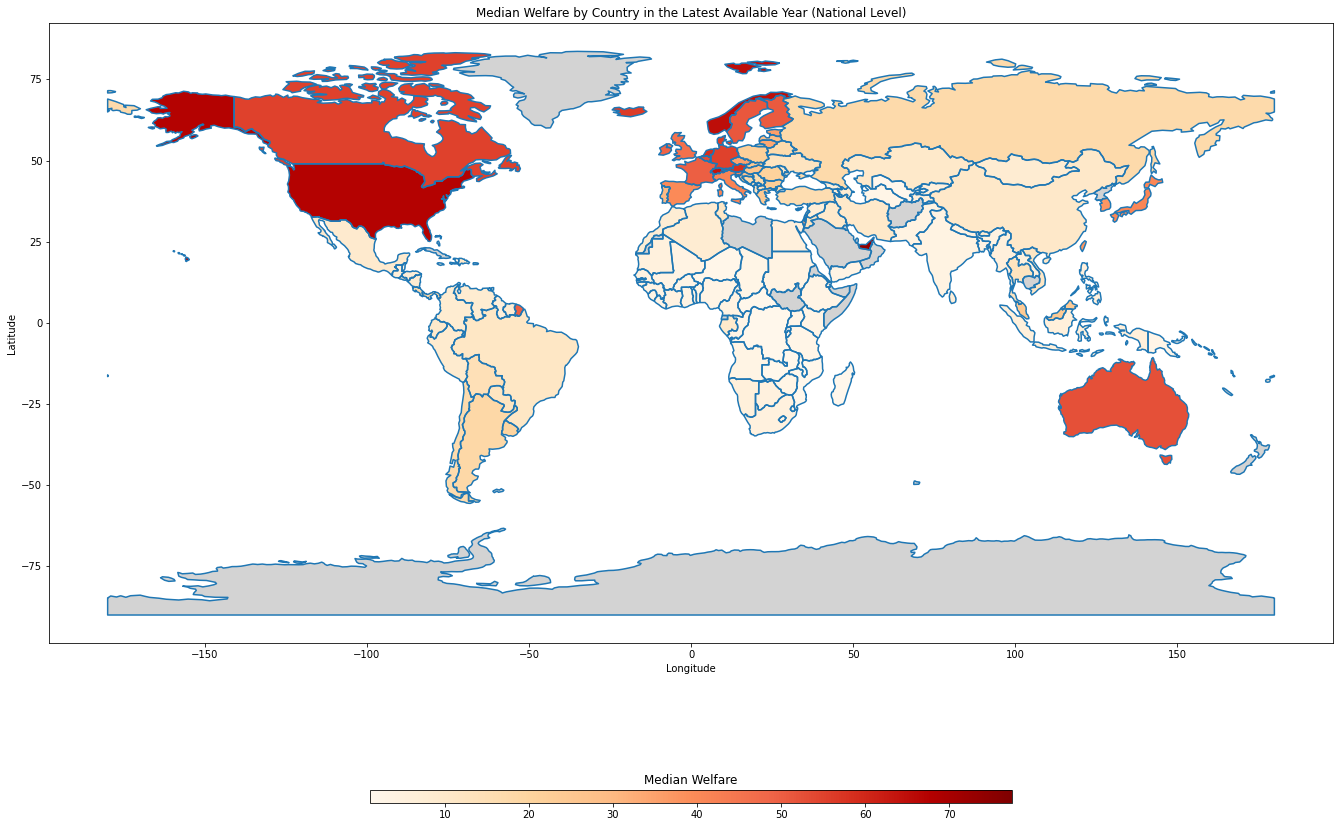

Data used for plotting:
     country_code  year welfare_type  med_welfare
2             AGO  2018  consumption     3.397974
17            ALB  2020  consumption    11.969770
19            ARE  2019       income    73.873136
2257          ARG  2021       income    18.200596
74            ARM  2021  consumption     6.711983
...           ...   ...          ...          ...
2204          XKX  2017  consumption     8.073222
2207          YEM  2014  consumption     3.409882
2213          ZAF  2014  consumption     4.698612
2222          ZMB  2015  consumption     1.546966
2225          ZWE  2019  consumption     2.624042

[168 rows x 4 columns]


In [ ]:
# Visualize 
shapefile_path = "/dbfs/FileStore/jingbin_c/ne_110m_admin_0_countries.shp"
world = read_shapefile_with_restore(shapefile_path)
df_visualization = visualize_poverty_world_map(median_welfare_df, world, key_column_world='ADM0_A3', key_column_df='country_code')

### Population data
Excel files with annual estimates and standard projection scenarios (Medium variant)

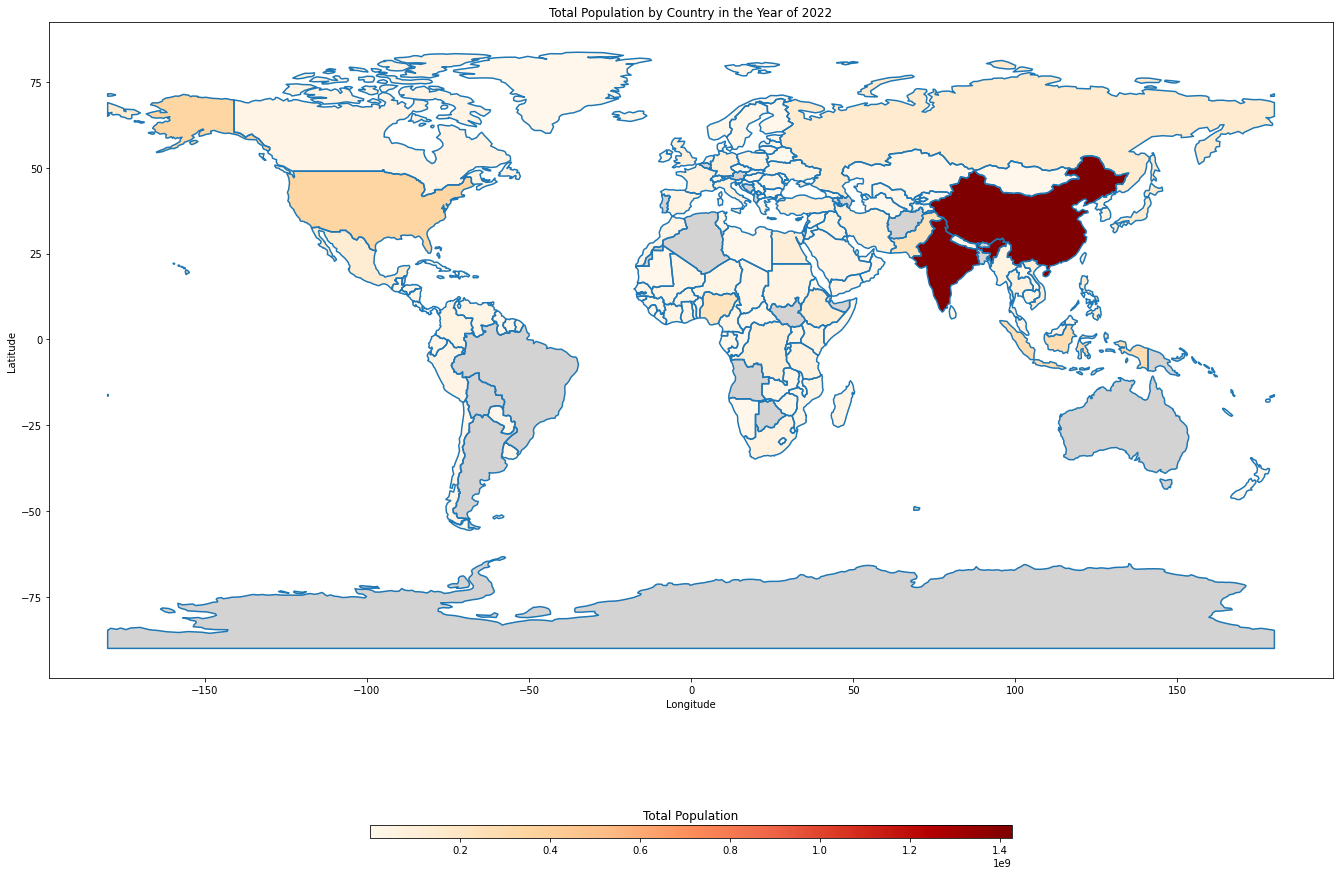

In [ ]:
# Generate Population data for year and append

file_path = '/dbfs/FileStore/jingbin_c/WPP2022_POP_F01_1_POPULATION_SINGLE_AGE_BOTH_SEXES.xlsx'

if YEAR >= 2022:
  sheet_name = 'Medium variant'
else:
  sheet_name = 'Estimates'

# Read data
df_population = read_excel_from_dbfs(file_path, sheet_name)

# Transform the DataFrame
df_population = transform_population_data(df_population, year = YEAR)


# Visualize Population data for 2022 as below in world map
visualize_population_world_map(df_population, world, key_column_world='SU_A3', key_column_df='country_code')

In [ ]:
# Generate historical populaiton data and future estimate

df_population_history = pd.DataFrame()

for YEAR in range(1950, 2101):
    if YEAR >= 2022:
        sheet_name = 'Medium variant'
    else:
        sheet_name = 'Estimates'
    
    df_population_temp = read_excel_from_dbfs(file_path, sheet_name)
    df_population_transformed = transform_population_data(df_population_temp, year=YEAR)
    
    df_population_history = pd.concat([df_population_history, df_population_transformed], ignore_index=True)

In [ ]:
df_population_history.to_csv('./data/time_track_world_population.csv')

### Snowflake Data 
Using yearly aggregated streaming data for Spotify

In [ ]:
YEAR = 2022

In [ ]:
df_consumer_stream = execute_snowflake_query(consumer_stream_sql(year = YEAR))

### Table manipulation and joining

In [ ]:
# Dictionary containing all regional DataFrames
region_dfs = {
    'ssa': ssa_df,
    'sea': sea_df,
    'na': na_df,
    'sam': sam_df,
    'eu': eu_df,
    'me': me_df,
    'ca': ca_df,
    'ea': ea_df,
    'sa': sa_df,
    'oc': oc_df,
    'cr': cr_df,
    'naf': naf_df,
    'dev': dev_df
}

In [ ]:
combined_df = pd.merge(df_population, df_visualization, on='country_code', how='left')

# Change welfare data to monthly
combined_df['med_welfare'] *= 30 

# Using the functions to clean and transform
cleaned_consumer_stream = clean_consumer_stream(df_consumer_stream)
combined_df = transform_combined_df(combined_df)

merged_df = pd.merge(cleaned_consumer_stream, combined_df, how='outer', 
                         left_on=['age_group', 'country_code'], 
                         right_on=['age_group', 'country_code_2_letter'])

merged_df = transform_merged_df(merged_df, YEAR)   

merged_df.to_csv(f'./data/summary_table_all_{YEAR}.csv')
# Save data to folder
merge_and_save(merged_df, region_dfs, year = YEAR)

Saved table to: ./data/summary_table_ssa_2022.csv
Saved table to: ./data/summary_table_sea_2022.csv
Saved table to: ./data/summary_table_na_2022.csv
Saved table to: ./data/summary_table_sam_2022.csv
Saved table to: ./data/summary_table_eu_2022.csv
Saved table to: ./data/summary_table_me_2022.csv
Saved table to: ./data/summary_table_ca_2022.csv
Saved table to: ./data/summary_table_ea_2022.csv
Saved table to: ./data/summary_table_sa_2022.csv
Saved table to: ./data/summary_table_oc_2022.csv
Saved table to: ./data/summary_table_cr_2022.csv
Saved table to: ./data/summary_table_naf_2022.csv
Saved table to: ./data/summary_table_dev_2022.csv


In [ ]:
merged_df

,consumer_access,age_group,total_stream_count,country_code_3_letter,country_code_2_letter,population_year,welfare_report_year,welfare_type,med_welfare_monthly,population,population_and_stream_year,stream_per_million_people
0,Paid,<18,20110563,COL,CO,2022.0,2021,income,256,13432616,2022,1497144
1,Free,<18,38676390,COL,CO,2022.0,2021,income,256,13432616,2022,2879289
2,Free,<18,525,COL,CO,2022.0,2021,income,256,13432616,2022,39
3,Free,<18,75,COL,CO,2022.0,2021,income,256,13432616,2022,6
4,Paid,<18,22112854,COL,CO,2022.0,2021,income,256,13432616,2022,1646206
...,...,...,...,...,...,...,...,...,...,...,...,...
16682,NaN,23-27,<NA>,YEM,YE,2022.0,2014,consumption,102,3067957,2022,<NA>
16683,NaN,28-34,<NA>,YEM,YE,2022.0,2014,consumption,102,3845968,2022,<NA>
16684,NaN,35-44,<NA>,YEM,YE,2022.0,2014,consumption,102,3739668,2022,<NA>
16685,NaN,45-59,<NA>,YEM,YE,2022.0,2014,consumption,102,2729765,2022,<NA>


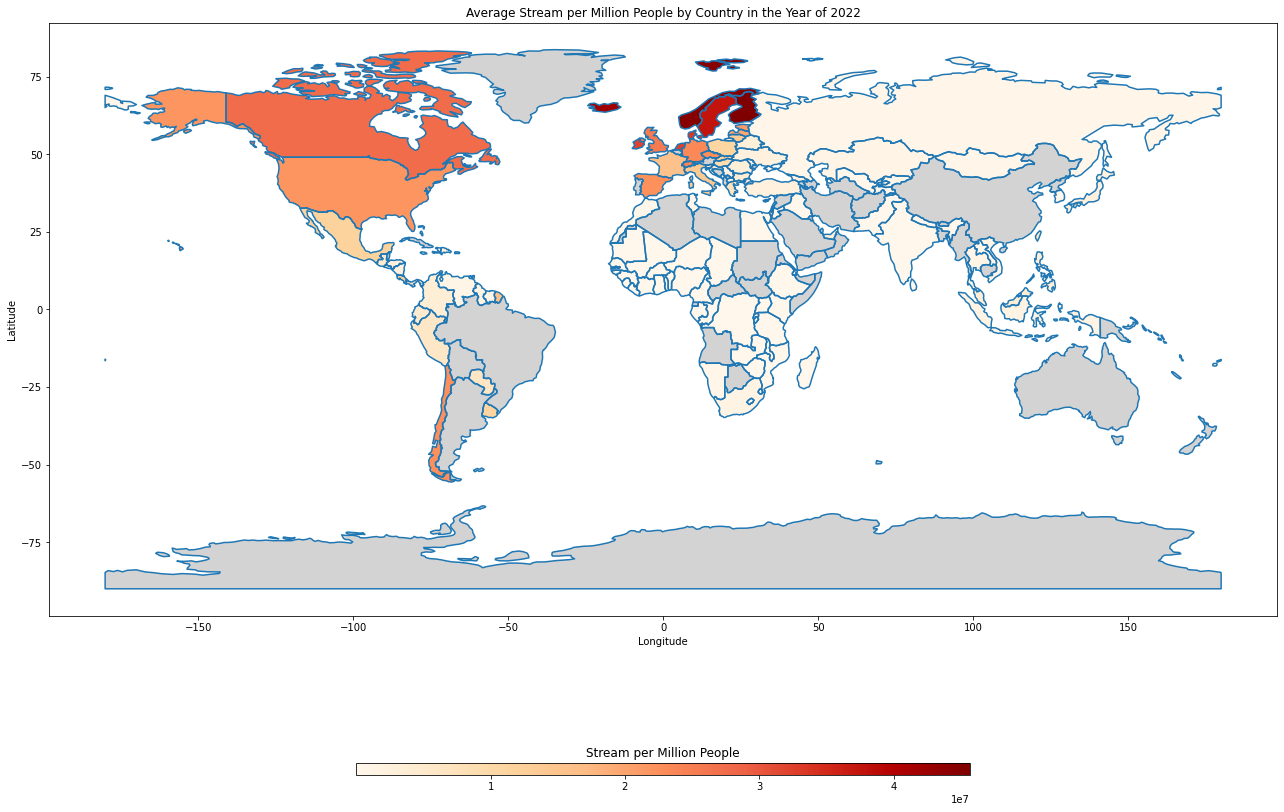

In [ ]:
# Visualize 2022 stream per million user in world map below
visualize_stream_world_map(merged_df, world, key_column_world='SU_A3', key_column_df='country_code_3_letter')

# Details of Data ETL

## Welfare Data
#### 1. Steps for `analyze_poverty_data_pandas` Function

1. **Initialize Empty List**: An empty list `all_insights` is initialized to store insights for each country.

2. **Read CSV File**: The function reads a CSV file from a given `file_path` into a DataFrame `df`.

3. **Convert Country Codes**: The function applies the `three_to_two_alpha` function on the 'country_code' column to create a new column 'country_code_2_letter'.

4. **Identify Unique Countries**: The unique country codes are identified and stored in `unique_countries`.

5. **Loop Through Countries**: For each unique country code in `unique_countries`, the following steps are performed:

    - **Country Data Filtering**: A new DataFrame `df_country` is created, filtered to only include rows for the specific country.

    - **Create Percentile Bins**: A new column 'Percentile_Bin' is created in `df_country` using pandas `cut` method, which categorizes the 'percentile' values into bins.

    - **Group and Aggregate Data**: A `groupby` operation is performed on `df_country` to aggregate data. This includes calculating the mean welfare, max and min quantiles, total population share, and total welfare share for each combination of variables.

    - **Flatten Multi-Level Columns**: The multi-level columns resulting from the aggregation are flattened.

    - **Rename Columns**: Columns are renamed for brevity.

    - **Append Insights**: The aggregated DataFrame is appended to `all_insights`.

6. **Concatenate All Insights**: All the individual DataFrames stored in `all_insights` are concatenated into a single DataFrame `concatenated_insights`.

7. **Return Result**: The function returns `concatenated_insights`, which contains the aggregated data for all countries.

These steps result in a DataFrame that provides a comprehensive analysis of poverty data by country, categorized by several variables including year, percentile bins, and welfare types.

### 2. Steps for `get_national_median_welfare` Function

1. **Data Filtering**: The function filters the original DataFrame (`df`) to only include rows where the `reporting_level` is either 'national', 'rural', or 'urban', and where the `percentile` is 50 (or whatever value is passed).

2. **Column Selection**: A new DataFrame (`filtered_df`) is created containing only the relevant columns ('country_code', 'year', 'reporting_level', 'welfare_type', 'avg_welfare').

3. **Group and Calculate Median**: A group-wise median calculation is performed on `filtered_df` to create `median_welfare_df`. It's grouped by 'country_code', 'year', 'reporting_level', and 'welfare_type'.

4. **New 'National' Rows**: A placeholder list (`new_national_rows`) is created to hold new 'national' rows that may need to be added.

5. **Iterate Unique Combinations**: For each unique combination of 'country_code', 'year', and 'welfare_type', the function fetches the rural and urban values (`rural_value` and `urban_value`) and calculates an average (`avg_value`).

   - If both rural and urban values are available, their average is taken.
   - If only one of them is available, that value is used as is.

6. **Append New Rows**: If new 'national' rows have been created, they are appended to `median_welfare_df`.

7. **Rename Column**: Finally, the column name 'avg_welfare' is renamed to 'med_welfare' to better represent the data.

By following these steps, the function produces a DataFrame that not only contains median welfare values but also fills in gaps in 'national' data where possible.


## Population Data

#### 1. `read_excel_from_dbfs`

**Purpose**: Reads an Excel file from a given DBFS (Databricks File System) file path and returns a DataFrame.

**Steps**:

1. **Import Required Libraries**: Import `pandas` for DataFrame manipulation.
2. **Read Excel File**: Read the Excel file located at `file_path` into a DataFrame. Skip the first 16 rows, assuming the variable names are on row 17.

#### 2. `convert_code_to_alpha`

**Purpose**: Converts a numerical country code to a 3-letter and 2-letter country code using the `pycountry` library.

**Steps**:

1. **Error Handling**: Use a `try-except` block to handle any invalid codes.
2. **Convert Codes**: Call the `pycountry.countries.get` method to convert the numeric country code to alpha-2 and alpha-3 codes.

#### 3. `transform_population_data`

**Purpose**: Transforms population data by filtering, renaming, and regrouping columns.

**Steps**:

1. **Rename Columns**: Rename the column from '100+' to '100'.
2. **Filter Data**: Filter the DataFrame to only include records from the specified year (default is 2022).
3. **Convert Country Codes**: Use the `convert_code_to_alpha` function to get the alpha-2 and alpha-3 country codes.
4. **Remove NA Rows**: Drop rows with NA values in ISO codes.
5. **Column Pruning**: Retain only the necessary columns.
6. **Grouping**: Group age ranges into broader categories.
7. **Cleanup**: Remove individual age columns and rename others.
8. **Scale**: Multiply all numerical values by 1000 to adjust the scale.
9. **Add Year Column**: Include a column specifying the year of the population data.



## WMG Data (Streaming)

#### `consumer_stream_sql`

**Purpose**: Generates an SQL query to fetch and join consumer details and audio streaming data, further aggregating the streaming count by consumer and age group for a specific year.

(Ignore for public)

## Data Limitation:

1. Poverty data has many missing values. maybe no income/consumption, maybe no national

2. Population data for 2022 is estimate

3. Spotify data might not accurate. Need to do data quality check as future work

4. Spotify miss several countries data, detail see world map

5. Using Spotify yearly agg data. Didn't get record for similarity and

# Visualization and Forecasting Plan During Work in Progress 
(Not use in the final project. Just a showcase for my thoughts in the middle ground)

**3 World Maps:**
1. Medium Welfare
2. Population
3. Stream per million people

    **Insights**
    1. Emerging markets has more poverty but more people
    2. Developed markets has more streams

**3 Charts:**
1. Charts for SEA and SSA, showing Free membership streams more
2. Charts for developed countries: US, CA, European some countries, Korea, Japan, etc.
3. Charts for population of each country (historical and prediction) **TODO**
4. Population with age_group for SEA and SSA Countries over the years (2 graphs)

    **Insights**
    1. Emerging markets **free** membership has more streams (per million people)
    2. Developed markets **paid** membership has more streams

**Tables**
1. In 2030, what is potential stream per million people we can get for emerging markets? (Given streams for developed countries, estimate the streams) 

**Business Questions:**
1. Which emerging markets (countries/regions) has potential to get Spotify membership? Given their poverty data. (Define threshold)
2. Which emerging markets (countries/regions) has more potential, and which should we reach out to? (Country/region pass the threshold)
3. For WMG, streams is more we care about. If more people pay membership, it might increase streams. Estimate streams in emerging markets (Logic below) 
4. If not push those emerging markets, will there still be streaming increase given the rise of population? Using historical population data (Logic below)


**TODO**

Define Threshold for some potential emerging markets given the merged_df, for example, med_welfare, streams_per_million_people

Follow below logic

## Logic:
First detect emerging markets (countries) based on several threshold

Then calculate estimated streams per million users (2030)
    
    For NOT targeted markets (fail for threshold) calcualte estimated streams based on current paid and unpaid streams
    For targeted markets, calculate estimated streams based on US/EU/JP paid and unpaid streams

    (estimated streams = streams_per_million_user * population in 2030)